# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
#Make sure data was imported correctly

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

In [4]:
#Helpter function to pivot from wide to long format

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#melted.groupby('time').aggregate({'value':'mean'})

In [5]:
# Drop columns that aren't included in the helper function

df.drop(columns=['RegionID','SizeRank'], axis=1, inplace=True)

In [6]:
# Ensure data is melted

df_melted = melt_data(df)
df_melted.head(5)

,RegionName,City,State,Metro,CountyName,time,value
0,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [7]:
# Set DataFrame to only show Texas values

df_texas = df_melted[df_melted['State']=='TX']

In [8]:
# Set index

df_texas.set_index('time', inplace=True)

In [9]:
# Set index as datetime object

df_texas.index = pd.to_datetime(df_texas.index)

# EDA and Visualization

## 2008 Housing Bubble Recovery Time

Look into correlation of results between two different bust cycles as % change values

In [10]:
def df_maker(df, county):
    """
    Takes a DataFrame and returns sliced version only including specified county
    Parameters:
    DataFrame, country
    Returns:
    DataFrame sliced to only include specified county
    """
    df = df_texas[df_texas['CountyName']==county].copy()
    return df

In [11]:
def county_dict_maker(df):
    """
    Takes a DataFrame and returns a dictionary where keys are zip codes and values
    are DataFrames with specified zip codes and median home values
    Parameters:
    DataFrame
    Returns:
    Dictionary with zip code keys and DataFrame values
    """
    df.drop(columns=['City', 'State', 'Metro', 'CountyName'], axis=1, inplace=True)
    zips=list(df['RegionName'].unique())
    dict_full = {}
    for zip_ in zips:
        dict_full[zip_] = df[df['RegionName']==zip_]
    return dict_full

In [12]:
# Try except because certain zip codes do not full into time constra
def housing_bust_finder(df, dict_full):
    """
    Takes a DataFrame and dictionary and returns a DataFrame where each zipcode specifies
    the number of days it took to reach the max price between 2005 and 2008 along with a dictionary
    showing the frequency of number of days to reach previous maximum value
    Parameters:
    DataFrame and dictionary
    Returns:
    DataFrame where each zipcode specifies the number of days until recovery and dictionary where
    keys are frequency and values are days until recovery
    """
    # Create list of unique zip codes in the region
    zips=list(df['RegionName'].unique())
    
    # Create dictionary where keys is zip code and value is days until recovery
    # Use try/except because certain zip codes will not correspond with necessary time frame
    recover_housing_dict = {}
    for zip_ in zips:
        for zip_, vals in dict_full.items():
            try:
                idx_max_pre = dict_full[zip_]['2005-01-01':'2008-12-31']['value'].idxmax()
                val_max_pre = dict_full[zip_]['2005-01-01':'2008-12-31']['value'].max()
                idx_max_post=(dict_full[zip_]['2008-12-30':]['value']>=val_max_pre).idxmax()
                td = idx_max_post - idx_max_pre
                days = td.days
                recover_housing_dict[zip_]=days
            except ValueError:
                pass
    
    # Create dictionary where key is number of days until recovery and value is frequency
    recover_housing_counts={}
    for k, v in recover_housing_dict.items():
        if v in recover_housing_counts.keys():
            recover_housing_counts[v] +=1
        else:
            recover_housing_counts[v] = 1
    
    # Swap keys and values and return the above dictionary in the form of a Pandas series
    housing_recover=pd.Series(recover_housing_counts)
    housing_recover=pd.Series(housing_recover.index.values, index=housing_recover)
    df_housing_recover=pd.DataFrame(housing_recover)
    df_housing_recover.rename(columns={0:'Days_Until_Recovery'}, inplace=True)
    df_housing_recover.sort_values(by='Days_Until_Recovery', ascending=True, inplace=True)
    return df_housing_recover, recover_housing_dict

In [13]:
df_texas['CountyName'].value_counts(1).nlargest(10)

Harris        0.125698
Dallas        0.071883
Tarrant       0.061291
Bexar         0.057135
Travis        0.046747
Denton        0.024932
Collin        0.024261
El Paso       0.021004
Montgomery    0.020776
McLennan      0.015857
Name: CountyName, dtype: float64

Create Travis county data

Create Harris county data

In [14]:
# Create Harris county DataFrame
df_Harris = df_maker(df_texas, 'Harris')

# Create Harris county dictionary
Harris_dict_full = county_dict_maker(df_Harris)

# Create Harris county recovery dataframe and dictionary
df_Harris_days, dict_Harris_zips = housing_bust_finder(df_Harris,Harris_dict_full)

Create Dallas county data

In [15]:
# Create Dallas county DataFrame
df_Dallas = df_maker(df_texas, 'Dallas')

# Create Dallas county dictionary
Dallas_dict_full = county_dict_maker(df_Dallas)

# Create Dallas county recovery dataframe and dictionary
df_Dallas_days, dict_Dallas_zips = housing_bust_finder(df_Dallas,Dallas_dict_full)

In [16]:
# Create Travis county DataFrame
df_Travis = df_maker(df_texas, 'Travis')

# Create Travis county dictionary
travis_dict_full = county_dict_maker(df_Travis)

# Create Travis county recovery dataframe and dictionary
df_Travis_days, dict_Travis_zips = housing_bust_finder(df_Travis,travis_dict_full)

Create Tarrant county data

In [17]:
# Create Tarrant county DataFrame
df_Tarrant = df_maker(df_texas, 'Tarrant')

# Create Tarrant county dictionary
Tarrant_dict_full = county_dict_maker(df_Tarrant)

# Create Tarrant county recovery dataframe and dictionary
df_Tarrant_days, dict_Tarrant_zips = housing_bust_finder(df_Tarrant,Tarrant_dict_full)

Create Bexar county data

In [18]:
# Create Bexar county DataFrame
df_Bexar = df_maker(df_texas, 'Bexar')

# Create Bexar county dictionary
Bexar_dict_full = county_dict_maker(df_Bexar)

# Create Bexar county recovery dataframe and dictionary
df_Bexar_days, dict_Bexar_zips = housing_bust_finder(df_Bexar,Bexar_dict_full)

Create Denton county data

In [19]:
# Create Denton county DataFrame
df_Denton = df_maker(df_texas, 'Denton')

# Create Denton county dictionary
Denton_dict_full = county_dict_maker(df_Denton)

# Create Denton county recovery dataframe and dictionary
df_Denton_days, dict_Denton_zips = housing_bust_finder(df_Denton,Denton_dict_full)

Create Collin county data

In [20]:
# Create Collin county DataFrame
df_Collin = df_maker(df_texas, 'Collin')

# Create Collin county dictionary
Collin_dict_full = county_dict_maker(df_Collin)

# Create Collin county recovery dataframe and dictionary
df_Collin_days, dict_Collin_zips = housing_bust_finder(df_Collin,Collin_dict_full)

Create El Paso county data

In [21]:
# Create El Paso county DataFrame
df_El_Paso = df_maker(df_texas, 'El Paso')

# Create El Paso county dictionary
El_Paso_dict_full = county_dict_maker(df_El_Paso)

# Create El Paso county recovery dataframe and dictionary
df_El_Paso_days, dict_El_Paso_zips = housing_bust_finder(df_El_Paso,El_Paso_dict_full)

Create Montgomery county data

In [22]:
# Create Montgomery county DataFrame
df_Montgomery = df_maker(df_texas, 'Montgomery')

# Create Montgomery county dictionary
Montgomery_dict_full = county_dict_maker(df_Montgomery)

# Create Montgomery county recovery dataframe and dictionary
df_Montgomery_days, dict_Montgomery_zips = housing_bust_finder(df_Montgomery,Montgomery_dict_full)

Create McLennan county data

In [23]:
# Create McLennan county DataFrame
df_McLennan = df_maker(df_texas, 'McLennan')

# Create McLennan county dictionary
McLennan_dict_full = county_dict_maker(df_McLennan)

# Create McLennan county recovery dataframe and dictionary
df_McLennan_days, dict_McLennan_zips = housing_bust_finder(df_McLennan,McLennan_dict_full)

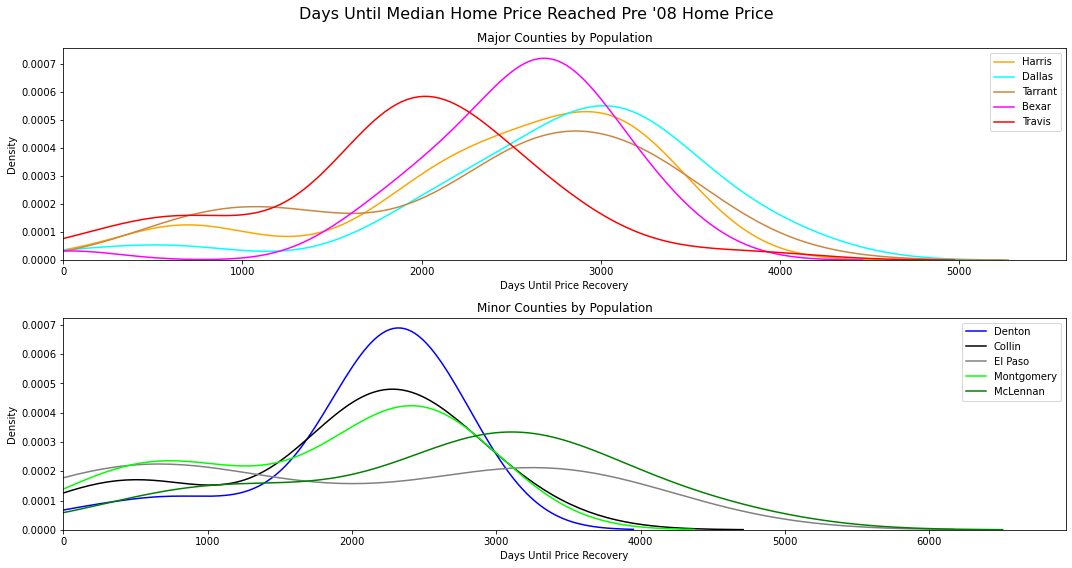

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(15,8), nrows=2)
fig.suptitle('Days Until Median Home Price Reached Pre \'08 Home Price', fontsize=16)
sns.kdeplot(data=df_Harris_days, ax=axes[0],label='Harris', palette=['orange'])
sns.kdeplot(data=df_Dallas_days, ax=axes[0],label='Dallas', palette=['cyan'])
sns.kdeplot(data=df_Tarrant_days, ax=axes[0],label='Tarrant', palette=['peru'])
sns.kdeplot(data=df_Bexar_days, ax=axes[0],label='Bexar', palette=['magenta'])
sns.kdeplot(data=df_Travis_days, ax=axes[0],label='Travis', palette=['red'])
axes[0].set_xlabel('Days Until Price Recovery')
axes[0].set_title('Major Counties by Population')
sns.kdeplot(data=df_Denton_days, ax=axes[1],label='Denton', palette=['blue'])
sns.kdeplot(data=df_Collin_days, ax=axes[1],label='Collin', palette=['black'])
sns.kdeplot(data=df_El_Paso_days, ax=axes[1],label='El Paso', palette=['grey'])
sns.kdeplot(data=df_Montgomery_days, ax=axes[1],label='Montgomery', palette=['lime'])
sns.kdeplot(data=df_McLennan_days, ax=axes[1],label='McLennan', palette=['green'])
axes[1].set_xlabel('Days Until Price Recovery')
axes[1].set_title('Minor Counties by Population')
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)
axes[0].legend()
axes[1].legend()
fig.tight_layout();

In [25]:
big_counties_names = ['Harris','Dallas','Tarrant','Bexar','Travis']
big_counties_df = [df_Harris_days, df_Dallas_days, df_Tarrant_days, df_Bexar_days, df_Travis_days]
big_recovery_agg = {}
for name, df in zip(big_counties_names, big_counties_df):
    big_recovery_agg[name] = df['Days_Until_Recovery'].agg(['mean', 'median', 'std', 'max'])
big_county_recovery = pd.DataFrame(big_recovery_agg).T
big_county_recovery.sort_values(by=['median', 'mean', 'std', 'max'])

,mean,median,std,max
Travis,1879.512821,1947.0,790.199304,3835.0
Tarrant,2405.063830,2619.0,926.935681,3986.0
Bexar,2537.119048,2646.5,611.639189,3592.0
Harris,2432.412500,2662.5,846.344899,3622.0
Dallas,2767.155556,2953.0,835.392748,4079.0


- **Travis:** Selected due to lowest mean/median
- Tarrant: Not selected due to high standard deviation
- **Bexar:** Selected due to moderate mean/median and lowest standard deviation
- **Harris:** Selected due to superior metrics to Dallas
- Dallas: Not selected

In [26]:
small_counties_names = ['Denton','Collin','El_Paso','Montgomery','McLennan']
small_counties_df = [df_Denton_days, df_Collin_days, df_El_Paso_days, df_Montgomery_days, df_McLennan_days]
small_recovery_agg = {}
for name, df in zip(small_counties_names, small_counties_df):
    small_recovery_agg[name] = df['Days_Until_Recovery'].agg(['mean', 'median', 'std', 'max'])
small_county_recovery = pd.DataFrame(small_recovery_agg).T
small_county_recovery.sort_values(by=['median', 'mean', 'std', 'max'])

,mean,median,std,max
El_Paso,1922.615385,1704.0,1416.997032,3623.0
Collin,1867.875000,2115.5,914.517058,3134.0
Montgomery,1749.888889,2176.5,931.835563,2800.0
Denton,2031.809524,2253.0,723.378782,2769.0
McLennan,2643.866667,3011.0,1165.708238,4473.0


- **El Paso:** Selected due to lowest mean/median, however high standard deviation
- **Collin:** Selected due to low median and low standard deviation
- Montgomery: Not selected due to high standard deviation
- **Denton:** Selected due to similar median/mean as Montgomery but lower standard deviation
- McLennan: Not selected

## Top Growth Prospects
- Based on recovery time further inspecting: Travis, Bexar, Harris, El Paso, Collin, and Denton county

In [27]:
def test_county_zip_perc(df_county, county_dict_full):
    """
    Takes a DataFrame and dictionary and returns a DataFrame where each zipcode specifies
    the 2-year, 5-year, 10-year/Std/Cumulative Score
    Parameters:
    DataFrame and dictionary
    Returns:
    DataFrame where each row is a zip code and values correspond to cumulative score, percent change,
    and standard deviation
    """
    county_dict_annual = {}
    county_zips = list(county_dict_full.keys())
    for zip_ in county_zips:
        county_dict_annual[zip_] = df_county[df_county['RegionName']==zip_].resample(rule='A').mean()
        county_dict_annual[zip_]['2_Year_Pct_Change'] = county_dict_annual[zip_]['value'].pct_change(periods=2)
        county_dict_annual[zip_]['5_Year_Pct_Change'] = county_dict_annual[zip_]['value'].pct_change(periods=5)
        county_dict_annual[zip_]['10_Year_Pct_Change'] = county_dict_annual[zip_]['value'].pct_change(periods=10)
        county_dict_annual[zip_]['Std'] = county_dict_annual[zip_]['value'].std()
    
    county_comparison = {}
    county_zips = list(county_dict_annual.keys())
    for zip_ in county_zips:
        for zip_, vals in county_dict_annual.items():
            county_comparison[zip_] = county_dict_annual[zip_].iloc[-1] 
    df = pd.DataFrame(county_comparison).T
    df.drop(columns='RegionName', inplace=True)
    df['Cumulative_Score'] = df['2_Year_Pct_Change']*(0.4)+df['5_Year_Pct_Change']*(0.35)+df['10_Year_Pct_Change']*(0.25)
    df.sort_values(by='Cumulative_Score', inplace=True, ascending=False)
    return df

In [28]:
county_name_by_recovery = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
county_df_by_recovery = [df_Travis, df_Bexar, df_Harris, df_El_Paso, df_Collin, df_Denton]
county_dict_by_recovery = [travis_dict_full, Bexar_dict_full, Harris_dict_full, 
                           El_Paso_dict_full, Collin_dict_full, Denton_dict_full]

In [29]:
all_perc_change_dict = {}
for name, df_, dict_ in zip(county_name_by_recovery, county_df_by_recovery, county_dict_by_recovery):
    all_perc_change_dict[name] = test_county_zip_perc(df_, dict_)
all_perc_change_dict

{'Travis':           value  2_Year_Pct_Change  5_Year_Pct_Change  10_Year_Pct_Change  \
 78721  296850.0           0.217097           0.952639            1.114567   
 78758  262900.0           0.195272           0.764035            0.829188   
 78744  193825.0           0.222292           0.708713            0.654267   
 78702  415250.0           0.125771           0.660059            0.807662   
 78741  245600.0           0.157444           0.695840            0.672645   
 78753  230175.0           0.192617           0.650000            0.664517   
 78745  293150.0           0.143182           0.574171            0.703700   
 78723  360150.0           0.157232           0.530816            0.737966   
 78727  314225.0           0.169318           0.566491            0.616522   
 78724  188175.0           0.158535           0.643689            0.457591   
 78752  301800.0           0.086850           0.575020            0.643791   
 78652  308500.0           0.099462           0.523206

In [30]:
all_perc_change_dict.keys()

dict_keys(['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton'])

In [31]:
all_perc_change_dict['Travis']

,value,2_Year_Pct_Change,5_Year_Pct_Change,10_Year_Pct_Change,Std,Cumulative_Score
78721,296850.0,0.217097,0.952639,1.114567,58590.974917,0.698904
78758,262900.0,0.195272,0.764035,0.829188,39196.613605,0.552818
78744,193825.0,0.222292,0.708713,0.654267,28778.317066,0.500533
78702,415250.0,0.125771,0.660059,0.807662,87127.794362,0.483245
78741,245600.0,0.157444,0.695840,0.672645,39486.554672,0.474683
78753,230175.0,0.192617,0.650000,0.664517,32468.946745,0.470676
78745,293150.0,0.143182,0.574171,0.703700,46600.385600,0.434158
78723,360150.0,0.157232,0.530816,0.737966,69494.086191,0.433170
78727,314225.0,0.169318,0.566491,0.616522,44970.317150,0.420130
78724,188175.0,0.158535,0.643689,0.457591,24835.144817,0.403103


In [32]:
def plot_top3_5(all_perc_change_dict, county_dict_full, region):
    
    top_5=list(all_perc_change_dict[region].index)[:5] 
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(county_dict_full[top_5[0]]['value'], color='red', label=top_5[0], lw=5)
        ax.plot(county_dict_full[top_5[1]]['value'], color='blue', label=top_5[1], lw=5)
        ax.plot(county_dict_full[top_5[2]]['value'], color='green', label=top_5[2], lw=5)
        ax.plot(county_dict_full[top_5[3]]['value'], color='black', label=top_5[3], lw=2, ls=':')
        ax.plot(county_dict_full[top_5[4]]['value'], color='silver', label=top_5[4], lw=2, ls=':')
        ax.set_title(f"{region} Top 5 Growth Zip Codes")
        ax.set_ylabel('Home Price')
        ax.set_xlabel('Year')
        ax.legend()
        return fig   

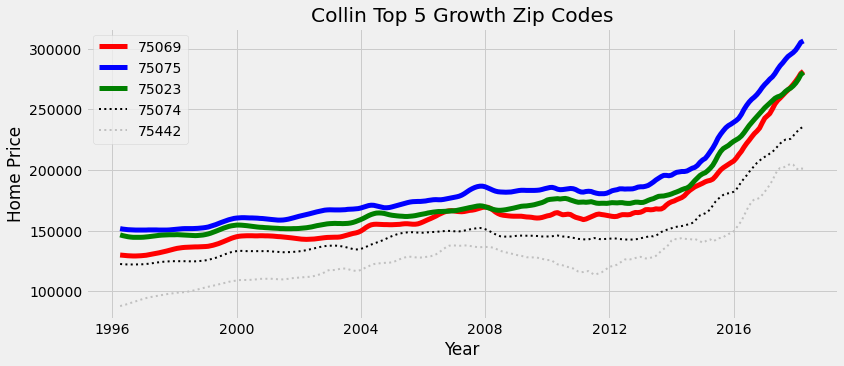

In [33]:
fig = plot_top3_5(all_perc_change_dict,Collin_dict_full,'Collin')
# fig = ax.get_figure()
ax = fig.get_axes()


In [34]:
county_name = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
county_dict_full = [travis_dict_full, Bexar_dict_full, Harris_dict_full, 
                           El_Paso_dict_full, Collin_dict_full, Denton_dict_full]

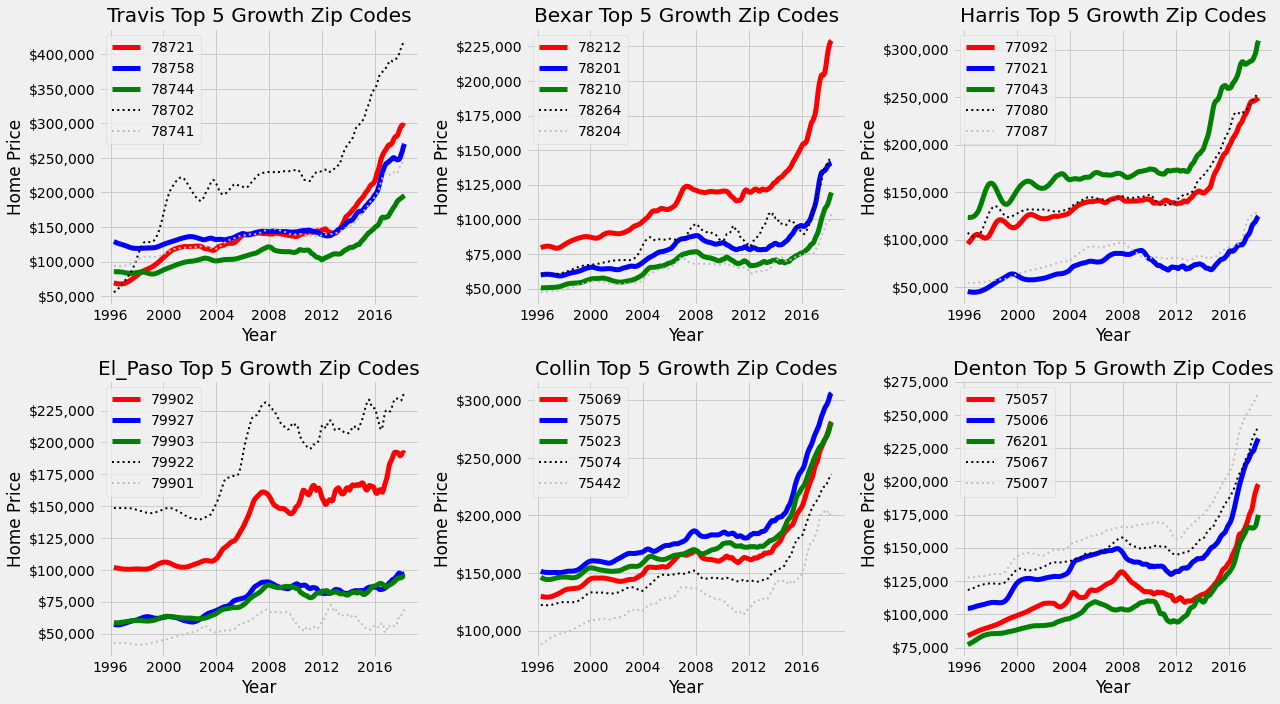

In [35]:
import matplotlib.ticker as mtick
county_name = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
county_dict_full = [travis_dict_full, Bexar_dict_full, Harris_dict_full, 
                           El_Paso_dict_full, Collin_dict_full, Denton_dict_full]

with plt.style.context('fivethirtyeight'):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
    for ax, name, dict_ in zip(axes.flatten(), county_name, county_dict_full):
        top_5=list(all_perc_change_dict[name].index)[:5]
        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.yaxis.set_major_formatter(tick) 
        sns.lineplot(data=dict_[top_5[0]]['value'], color='red', label=top_5[0], lw=5, ax=ax)
        sns.lineplot(data=dict_[top_5[1]]['value'], color='blue', label=top_5[1], lw=5, ax=ax)
        sns.lineplot(data=dict_[top_5[2]]['value'], color='green', label=top_5[2], lw=5, ax=ax)
        sns.lineplot(data=dict_[top_5[3]]['value'], color='black', label=top_5[3], lw=2, ls=':', ax=ax)
        sns.lineplot(data=dict_[top_5[4]]['value'], color='silver', label=top_5[4], lw=2, ls=':', ax=ax)
        ax.set_title(f"{name} Top 5 Growth Zip Codes")
        ax.set_ylabel('Home Price')
        ax.set_xlabel('Year')
        ax.legend()
        fig.tight_layout()

In [36]:
# Create a dictionary with each region and the top 3 zips and then create list of top 3 zips

In [37]:
county_name = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
top_zip_per_county = {}
for county in county_name:
    top_zip_per_county[county]=list(all_perc_change_dict[county].index)[:3]

In [38]:
top_zip_per_county

{'Travis': [78721, 78758, 78744],
 'Bexar': [78212, 78201, 78210],
 'Harris': [77092, 77021, 77043],
 'El_Paso': [79902, 79927, 79903],
 'Collin': [75069, 75075, 75023],
 'Denton': [75057, 75006, 76201]}

In [39]:
total_top_zips = []
for k, v in top_zip_per_county.items():
    total_top_zips.extend(v)
total_top_zips

[78721,
 78758,
 78744,
 78212,
 78201,
 78210,
 77092,
 77021,
 77043,
 79902,
 79927,
 79903,
 75069,
 75075,
 75023,
 75057,
 75006,
 76201]

Get the bars to show price change on one side and the other axis in histograms of different prices per year

Show summary statistics for the top zipcodes. what would i show given there's only one datapoint except for time per zip

In [40]:
df_travis_test = travis_dict_full[78721]['value'].resample(rule='A').mean().to_frame().copy()

In [41]:
df_travis_test['yearly_change'] = df_travis_test.pct_change(periods=1)

In [42]:
df_travis_test.tail()

,value,yearly_change
time,,
2014-12-31,178141.666667,0.171792
2015-12-31,203225.000000,0.140806
2016-12-31,243900.000000,0.200148
2017-12-31,277683.333333,0.138513
2018-12-31,296850.000000,0.069023


In [43]:
plot_df = df_travis_test.copy().reset_index()
plot_df

,time,value,yearly_change
0,1996-12-31,68111.111111,NaN
1,1997-12-31,72766.666667,0.068352
2,1998-12-31,85675.000000,0.177393
3,1999-12-31,96925.000000,0.131310
4,2000-12-31,113108.333333,0.166968
5,2001-12-31,121033.333333,0.070066
6,2002-12-31,122150.000000,0.009226
7,2003-12-31,117891.666667,-0.034862
8,2004-12-31,123200.000000,0.045027
9,2005-12-31,129933.333333,0.054654


In [44]:
df_travis_test.index

DatetimeIndex(['1996-12-31', '1997-12-31', '1998-12-31', '1999-12-31',
               '2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31',
               '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31',
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='time', freq='A-DEC')

# Step 4: Reshape from Wide to Long Format

In [45]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 5: ARIMA Modeling
- Showing all helper modeling functions

In [129]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 

def find_auto_order(df_train):
    """
    Takes a DataFrame and returns ARMA and Seasonal order based on auto_arima calculations
    Parameters:
    Train data
    Returns:
    Summary of auto_arima findings and ARMA/Seasonal order
    """
    model = auto_arima(df_train,start_p=1, start_q=1, max_p=4, max_q=4, start_P=1,#d=1, D=1,
    start_Q=1, max_d=3, max_D=3, max_Q=4, max_P=4,seasonal=True, m=12, with_intercept=True) #trace=True, stepwise=False)
    summary = model.summary()
    ARMA_order = model.order
    seasonal_order = model.seasonal_order
    return summary, ARMA_order, seasonal_order

In [146]:
# def SARIMAX_man_results(train_data, arma_order, seasonal_order):
#     """
#     Takes a training data and ARMA/Seasonal order and fits a SARIMAX model with specied order and fits
#     different parameters and returns the best SARIMAX model based on AIC value
#     Parameters:
#     Train data, seasonal/arma order
#     Returns:
#     Dictionary with various iterations of parameters and their AIC score and dictionary with the best 
#     parameters
#     """
#     model = SARIMAX(train_data,order=arma_order, seasonal_order=seasonal_order,
#                 enforce_stationarity=False, enforce_invertibility=False,
#                 freq='MS', k_trend=2)
#     results = model.fit()
#     score_ = results.aic

    
    
#     diagnostics = results.plot_diagnostics(figsize=(8,8))
#     results_dict['diag_summary'] = diagnostics

#     best_params['arma_order'] = arma_order
#     best_params['seasonal_order'] = seasonal_order
    


#     return results_dict, best_params

In [172]:
def fit_final_model(df_train, arma_order, seasonal_order):
    """
    Fit final model according to results from SARIMAX grid search
    Parameters:
    Train data, ARMA/Seasonal order, MLE_regression, and concentrate scale
    Returns:
    Fit model on traning data
    """
    model = SARIMAX(df_train,order=arma_order,seasonal_order=seasonal_order, enforce_invertibility=False, 
                    enforce_stationarity=False, freq='MS', k_trend=2)
    best_model = model.fit(maxiter=150)
    return best_model

In [160]:
def get_forecast(best_model, test_data):
    """
    Takes a fitted model and returns dataframe where index is a time and values are confidence interval
    and predicted mean
    Parameters:
    Fitted model and test data
    Returns:
    DataFrame showing predictions to compare to test data
    """
    forecast = best_model.get_forecast(steps=len(test_data))

    ## save forecasted mean and upper/lower ci as df
    forecast_df = forecast.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df
    return forecast_df

In [161]:
def plot_forecast(train_data, test_data, prediction_table, code, county):
    """
    Plot forecasted predictions as opposed to test data
    Parameters:
    Training data, test data, predictions, and zip code
    Returns:
    Plot comparing predictions based off fitted model to test data
    """
    with plt.style.context('fivethirtyeight'):
        fig,ax = plt.subplots(figsize=(10,4))

        # Plotting Training and test data
        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.yaxis.set_major_formatter(tick) 
        train_data['2014-01-01':].plot(label='Training Data')
        test_data['2014-01-01':].plot(label='Test Data')

        ## Plotting Forefcast and CI
        prediction_table['Forecast'].plot(ax=ax,label='Forecast')
        ax.fill_between(prediction_table.index,
                        prediction_table['Lower CI'], 
                        prediction_table['Upper CI'],color='g',alpha=0.3)

        ax.set(ylabel=f'{code} Home Value')
        ax.legend()
        ax.set_title(f"{county} County - {code} Current Predictions")
        
        return fig;

In [169]:
def fitall_final_model(df_all, arma_order, seasonal_order):
    """
    Fits final model on all data using specified parameters
    Parameters:
    Zip code dataframe, final model best parameters
    Returns:
    Best fit model on all data
    """
    model = SARIMAX(df_all,order=arma_order,seasonal_order=seasonal_order, enforce_invertibility=False, 
                    enforce_stationarity=False, freq='MS')
    bestall_model = model.fit()
    return bestall_model

In [163]:
# Rerun on entire dataset to get further forecasts
import matplotlib.ticker as mtick

def plot_future_forecast(final_model, test_data, train_data, code, county):
    """
    Plot showing traing data, test data, and future predictions out to July 1st 2020
    Parameters:
    Final model, test data, training data, zip code, and county
    Returns:
    Plot showing training, test, and future values. Dictionary of final value low, high, and mean
    confidicene interval. Dataframe showing all future predictions
    """
    with plt.style.context('fivethirtyeight'):
    
        ## Get forecast
        forecast = final_model.get_forecast(steps=len(test_data))

        ## save forecasted mean and upper/lower ci as df
        forecast_dict={}
        forecast_df = forecast.conf_int()
        forecast_df.columns = ['Lower CI','Upper CI']
        forecast_df['Forecast'] = forecast.predicted_mean
        forecast_dict['low'] = forecast_df.iloc[-1]['Lower CI']
        forecast_dict['high'] = forecast_df.iloc[-1]['Upper CI']
        forecast_dict['mean'] = forecast_df.iloc[-1]['Forecast']

        ## Plot
        last_n_lags=52

        fig,ax = plt.subplots(figsize=(10,4))


        # Plotting Training and test data
        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.yaxis.set_major_formatter(tick) 
        ax.plot(train_data['2012-01-01':], label='Training Data')
        ax.plot(test_data['2012-01-01':], label='Test Data')
        ax.axvline(train_data.index[-1],ls=':')
        ax.set_xlabel('Year')
        ax.set_ylabel('Home Value')
        ax.set_title(f"{county} County - {code} Future Predictions")
        

        ## Plotting Forefcast and CI
        ax.plot(forecast_df['Forecast'], label='Forecast')
        ax.fill_between(forecast_df.index,
                        forecast_df['Lower CI'], 
                        forecast_df['Upper CI'],color='g',alpha=0.3)
        ax.legend(loc=2)
        return fig, forecast_dict, forecast_df

In [164]:
def roi_dict(forecast_df):
    forecast_dict = {}
    cols = ['Lower CI', 'Upper CI', 'Forecast']
    for col in cols:
        perc_change=(forecast_df[col][-1]-forecast_df[col][0])/forecast_df[col][0]
        dollar_val=(perc_change+1)*100000
        dollar_dif = dollar_val-100000
        forecast_dict[col]=[]
        forecast_dict[col].append(perc_change)
        forecast_dict[col].append(dollar_val)
        forecast_dict[col].append(dollar_dif)
    return forecast_dict

In [173]:
# Bring in ticker formats
import matplotlib.ticker as mtick

def model_predictions(train_data, test_data, all_data, code, county):
    """
    Uses all helper functions to create diagnostic summary, forecast on test data, and future predictions
    Parameters:
    Training data, test data, all data, zip code, and county
    Returns:
    Plot showing diagnostics and forecasts. Dictinary with predictions in the future
    """
    summary, arma_order, seasonal_order = find_auto_order(train_data)
#     best_params = SARIMAX_man_results(train_data, arma_order, seasonal_order)
    best_model = fit_final_model(train_data, arma_order, seasonal_order)
    forecast_df=get_forecast(best_model, test_data)
    test_forecast_fig=plot_forecast(train_data, test_data, forecast_df, code, county)
    bestall_model=fitall_final_model(all_data, arma_order, seasonal_order)
    
    fig, forecast_dict, forecast_df=plot_future_forecast(bestall_model, test_data, train_data, code, county)
    roi_helper = roi_dict(forecast_df)
    return fig, forecast_dict, forecast_df, roi_helper

## Travis County Modeling

Maybe add map image
Add df with all zips to do a describe

### 78758: EDA and SARIMAX

In [111]:
def create_zip_data (dict_full, zip_):
    """
    Takes a county dictionary and returns dataframe with values for specified zip code
    Parameters:
    Dictionary and zip code
    Returns:
    DataFrame which shows value and frequency is corrected to monthly data
    """
    df = dict_full[zip_].copy()
    df.drop(columns='RegionName', axis=1, inplace=True)
    df=df.resample('MS').asfreq()
    return df

In [112]:
df_78758=create_zip_data(travis_dict_full, 78758)

In [113]:
df_78758.describe()

,value
count,265.000000
mean,149549.056604
std,34194.863952
min,119000.000000
25%,131900.000000
50%,139900.000000
75%,145000.000000
max,270400.000000


In [114]:
def zip_eda(df_full, code, county):
    """
    Takes a zip code and returns historic prices, price distributions, and series of boxplots where each
    box represents a year of data to better assess spread of prices
    Parameters:
    DataFrame, zip code, and county
    Returns:
    Summary figure and descriptive statistics per zip code
    """

    from matplotlib.gridspec import GridSpec
    with plt.style.context('bmh'):
        
        fig = plt.figure(figsize=(19, 7), constrained_layout=False)
        gs = GridSpec(nrows=2, ncols=2)
        # First axes
        
        ax0 = fig.add_subplot(gs[0, 0])
        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax0.yaxis.set_major_formatter(tick) 
        ax0.plot(df_full['value'], color='r')
        ax0.set_title(f'{code} Price History')
        ax0.set_xlabel('Year')
        ax0.set_ylabel('Home Price')
        ax0.axvline(x='2000-01-01', label='Dotcom Boom', ls=':')
        ax0.axvline(x='2008-01-01', label='Housing Boom', ls=':', color='k')
        ax0.legend()
        # Second axes
        ax1 = fig.add_subplot(gs[1, 0])
        ax1.xaxis.set_major_formatter(tick) 
        sns.kdeplot(df_full['value'], ax=ax1, color='r')
        ax1.set_title(f'{code} Price Distribution')
        ax1.set_xlabel('Home Price')

        mean=df_full['value'].mean()
        median=df_full['value'].median()
        ax1.axvline(x=mean, label=f"Mean: ${round(mean,2)}", ls=':', color='blue')
        ax1.axvline(x=median, label=f"Median: ${round(median,2)}", ls=':', color='k')
        ax1.legend()
        # Third axes

        groups = df_full['1997-01-01':'2017-12-12'].groupby(pd.Grouper(freq='A'))
        df_annual=pd.DataFrame()
        for name, group in groups:
            df_annual[name.year]=group.values.ravel()
        ax2 = fig.add_subplot(gs[:, 1])
        ax2.yaxis.set_major_formatter(tick) 
        sns.boxplot(data=df_annual, ax=ax2)
        xticklabels = (range(1997,2018))
        ax2.set_xlabel('Year')
        ax2.set_xticklabels(xticklabels, rotation = 45, ha="right")
        ax2.set_title('Yearly Distribution of Median Home Prices')

        fig.suptitle(f'{county} County - {code}', fontsize=20)
        fig.tight_layout();
        res = df_full.describe()
        return fig, res;  

(<Figure size 1368x504 with 3 Axes>,
                value
 count     265.000000
 mean   149549.056604
 std     34194.863952
 min    119000.000000
 25%    131900.000000
 50%    139900.000000
 75%    145000.000000
 max    270400.000000)

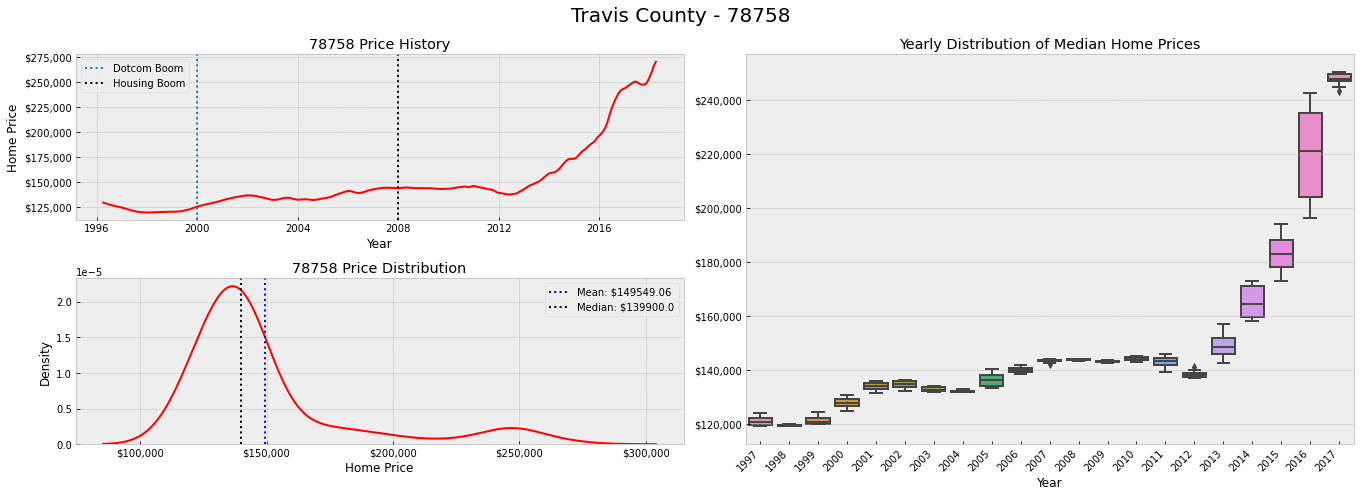

In [115]:
zip_eda(df_78758, 78758, 'Travis')

- Minimal impact on prices during dotcom crash and housing bust
- Data is right skewed based on mean > median
- From 1997 to 2012 homes have minimal spread but begin to increase after that with significantly larger spread in 2016

<AxesSubplot:xlabel='time'>

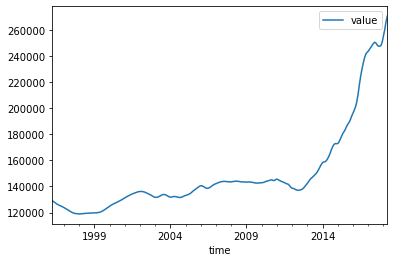

In [116]:
# Plot data to determine accurate split point

df_78758.plot()

In [117]:
def create_train_test_split(df_full, split):
    """
    Takes a DataFrame and split value and divides data into train/test based on percentage allocated
    to training
    Parameters:
    DataFrame and split value
    Returns:
    Train and test data with size specified by split value
    """
    total_rows=len(df_full)
    train = df_full.iloc[:int(total_rows*split)]['value']
    test = df_full.iloc[int(total_rows*split):]['value']
    return train, test

<AxesSubplot:xlabel='time'>

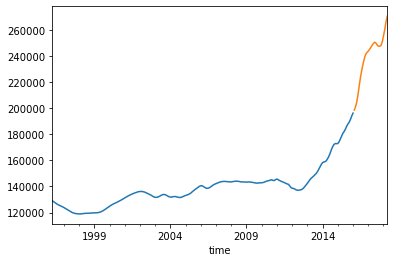

In [118]:
train_78758, test_78758 = create_train_test_split(df_78758, 0.9)
train_78758.plot()
test_78758.plot()

Split point looks like it accurately captures upward trend after 2014

In [119]:
# Create diagnostic helper function
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import adfuller

def pacf_acf_rolling(train, county, zip_, lags=30):
    with plt.style.context('bmh'):
    
        train=train.to_frame()
        fig = plt.figure(figsize=(19, 7), constrained_layout=False)
        gs = GridSpec(nrows=2, ncols=2)
        lags=30
        
        # First axes
        ax0 = fig.add_subplot(gs[0, 0])
        plot_acf(train['value'],lags=lags, ax=ax0);
        ax0.set_title('ACF Plot')

        # Second axes
        ax1 = fig.add_subplot(gs[1, 0])    
        plot_pacf(train['value'],lags=lags, ax=ax1)
        ax1.set_title('PACF Plot')


        # Third axes
        ax2 = fig.add_subplot(gs[:, 1])   
        
        train['12-month-SMA'] = train['value'].rolling(window=12).mean()
        train['12-month-Std'] = train['value'].rolling(window=12).std()
        ax2.plot(train['value'], label='Original Price')
        ax2.plot(train['12-month-SMA'], label='12-month-SMA')
        ax2.plot(train['12-month-Std'], label='12-month-Std')
        ax2.set_title('Rolling Window with Price')
        ax2.legend()

        fig.suptitle(f'{county} County - {zip_}', fontsize=20)
        fig.tight_layout();
        
        # Dickey Fuller
        print('Augmented Dickey-Fuller Test on 78722')
        dftest = adfuller(train['value'])
        dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])
        for key,val in dftest[4].items():
            dfout[f'critical value ({key})']=val
        print(dfout)

Augmented Dickey-Fuller Test on 78722
ADF test statistic        0.835024
p-value                   0.992181
# lags used              12.000000
# observations          225.000000
critical value (1%)      -3.459752
critical value (5%)      -2.874473
critical value (10%)     -2.573663
dtype: float64


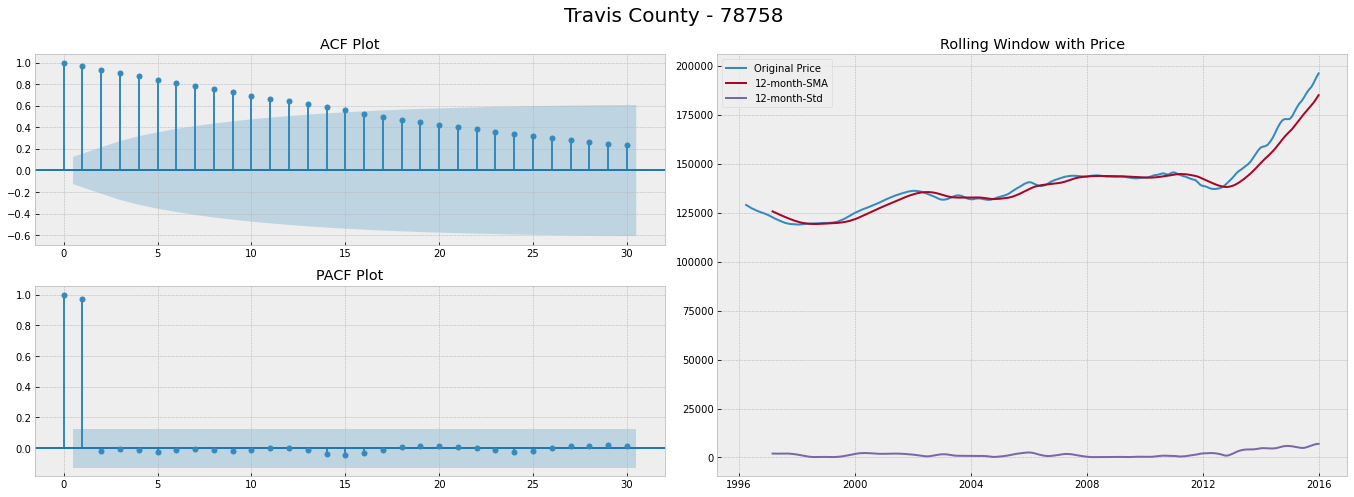

In [120]:
pacf_acf_rolling(train_78758, 'Travis', 78758)

- ACF plot suggests data is not stationary because it has a downward gradual slope
    - Significant correlation up to 15 lags 
- PACF plot drops off steeply after first lag suggesting little relationship to time
- Standard deviation picks up around 2013 and there is a clear upward trend at this time

In [121]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomposition(train, county, zip_, model_type='Additive'):
    # Gather the trend, seasonality, and residuals 
    train=train.to_frame()
    decomposition = seasonal_decompose(train['value'],model=model_type)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    with plt.style.context('fivethirtyeight'):
        
        plt.figure(figsize=(12,8))
        plt.subplot(411, title=f'{county} County - {zip_}')
        plt.plot(train['value'], label='Original', color='blue')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color='blue')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color='blue')
        plt.legend(loc='best')
        plt.tight_layout()

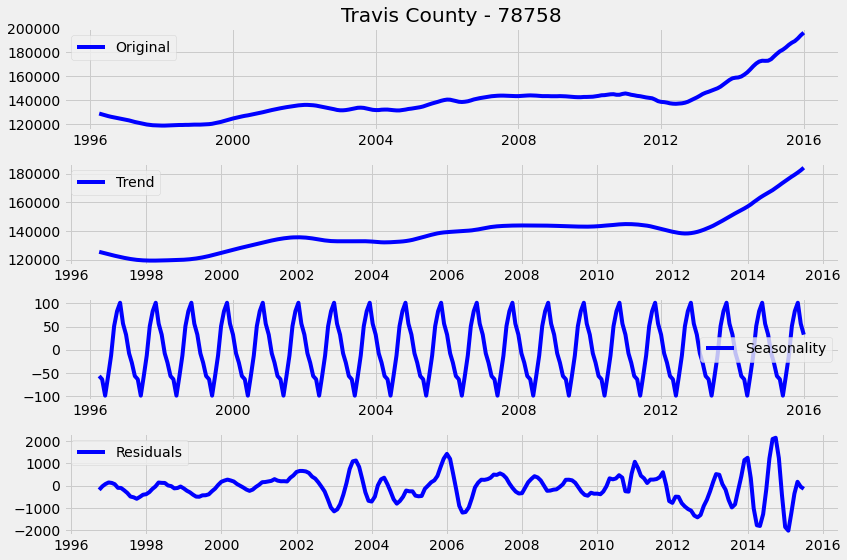

In [122]:
seasonal_decomposition(train_78758, 'Travis', 78758)

- There is an upward trend beginning in 2013
- Data is seasonal wiht peaks in the summer months (June-Sept) and dips in the winter months
- Seasonality appears constant
- Residuals suggest more variance after the upward trend in 2013

In [ ]:
fig_78758, future_78758, forecast_df_78758, roi_78758 = model_predictions(train_78758, test_78758, df_78758, 78758, 'Travis')

- Current predictions
    - Model captures general trend compared to test predictions
    - Confidence interal does a better job at capturing values after July 2017
- Future predictions
    - Model continues to follow general trend upward
    - Has a descent in mid-2019 and then continues upwards
- An investment of \$100,000 today (05/01/2018) by 07/01/2020 would yield (ROI):
    - Conservative estimate: 10.3\% (\$10,349)
    - Mean estimate: 24.5% (\$24,557)
    - Upper estimate: 39.0\% (\$38,986)

### 78721: EDA AND SARIMAX

In [68]:
# Create 78721 dataframe

df_78721=create_zip_data(travis_dict_full, 78721)

(<Figure size 1368x504 with 3 Axes>,
                value
 count     265.000000
 mean   143692.452830
 std     51937.036652
 min     67600.000000
 25%    118700.000000
 50%    138800.000000
 75%    144600.000000
 max    297800.000000)

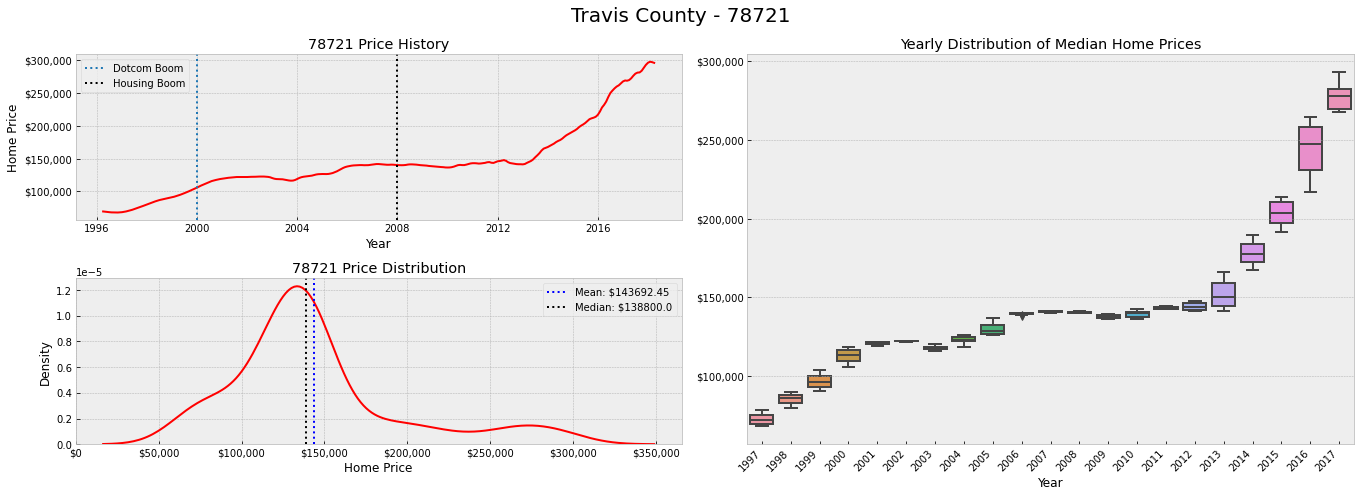

In [69]:
zip_eda(df_78721, 78721, 'Travis')

- Minimal impact on prices during dotcom crash and housing bust
- No large downturn but prices were stagnant between 2008 and 2012 before rising again
- Data is right skewed based on mean > median
- From 1997 to 2012 homes have minimal spread but begin to increase after that with significantly larger spread in 2013 and 2016

<AxesSubplot:xlabel='time'>

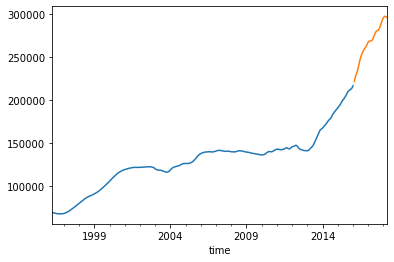

In [70]:
train_78721, test_78721 = create_train_test_split(df_78721, 0.9)
train_78721.plot()
test_78721.plot()

Split point looks like it accurately captures upward trend after 2013

Augmented Dickey-Fuller Test on 78722
ADF test statistic        0.666011
p-value                   0.989135
# lags used               9.000000
# observations          228.000000
critical value (1%)      -3.459361
critical value (5%)      -2.874302
critical value (10%)     -2.573571
dtype: float64


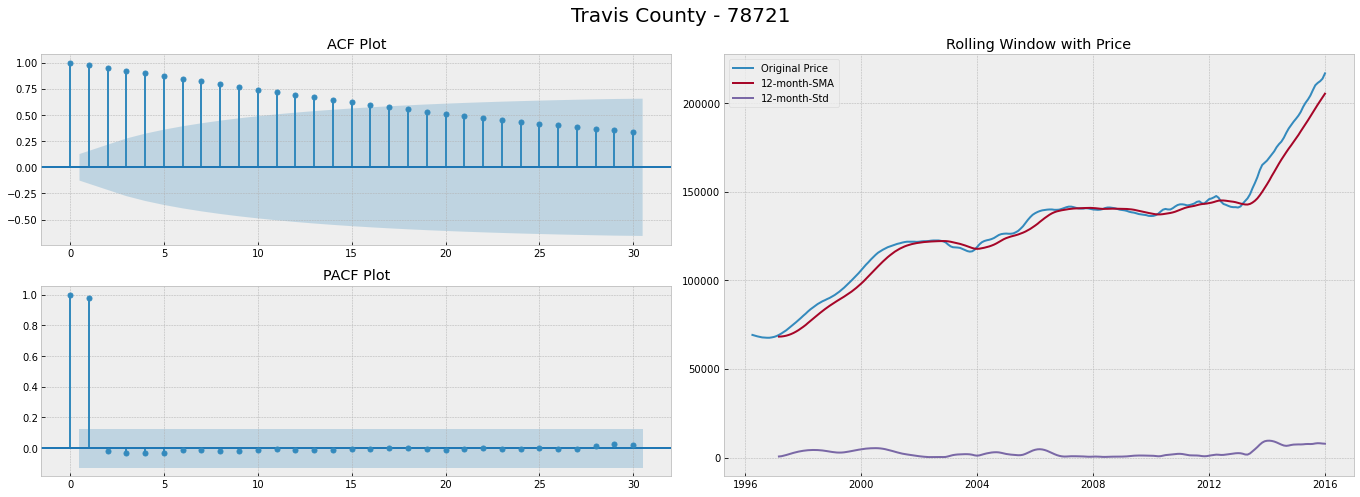

In [71]:
pacf_acf_rolling(train_78721, 'Travis', 78721)

- Based on Dickey Fuller test result data is not stationary, 0.99 > 0.05
- ACF plot suggests data is not stationary because it has a downward gradual slope
    - Significant correlation up to 16 lags 
- PACF plot drops off steeply after first lag suggesting little relationship to time
- Standard deviation picks up around 2013 and there is a clear upward trend at this time
- 12 month rolling average follows original data closely

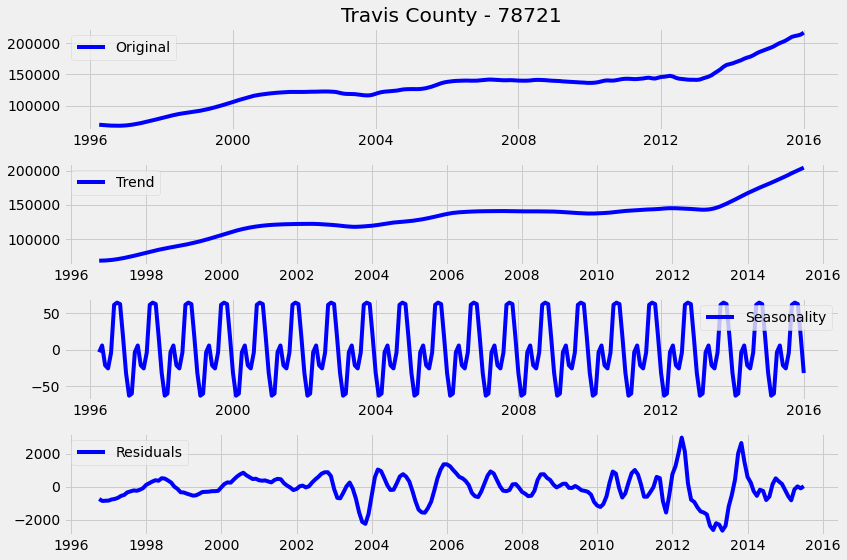

In [72]:
seasonal_decomposition(train_78721, 'Travis', 78721)

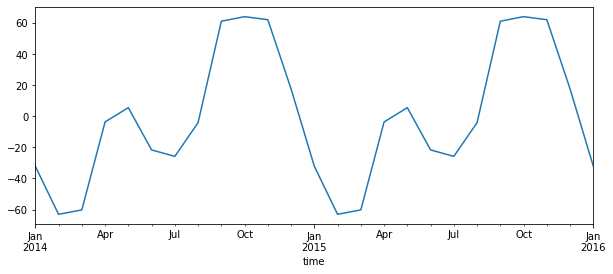

In [73]:
decomposition = seasonal_decompose(train_78721,model='Additive')
seasonal = decomposition.seasonal
seasonal.plot(figsize=(10,4), xlim=('2014-01-01', '2016-01-01'));

- There is an upward trend beginning in 2013
- Data is annually seasonal with peaks in months (Aug-Nov) and dips in (Feb-July)
- Seasonality appears constant
- Residuals suggest more variance after the upward trend in 2013, however they appear to borderline
homoskedastic
- Looks like data needs 1 degree of differencing on seasonality

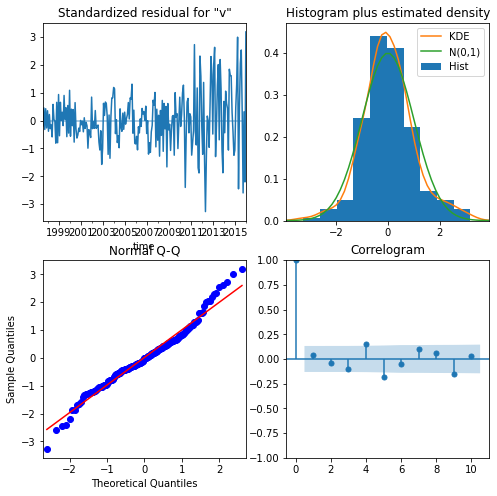

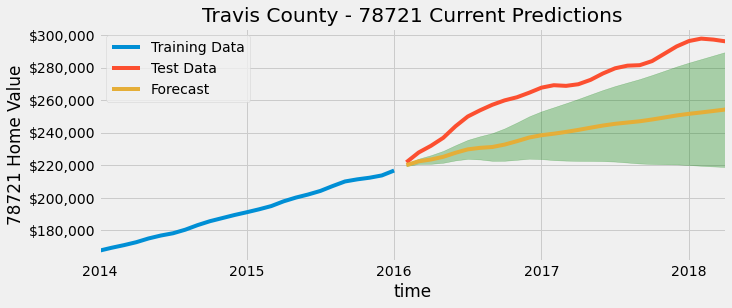

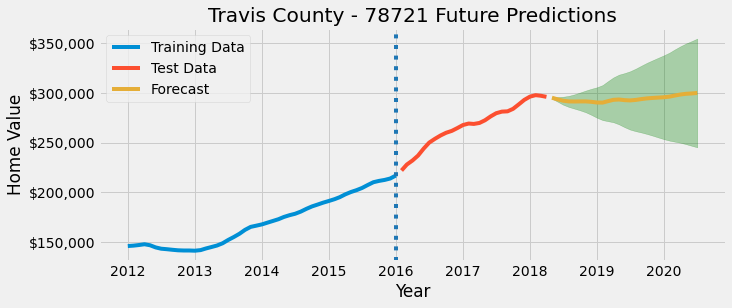

In [74]:
fig_78721, future_78721, forecast_df_78721, roi_78721 = model_predictions(train_78721, test_78721, df_78721, 78721, 'Travis')

In [75]:
roi_78721

{'Lower CI': [-0.16666393702657062, 83333.60629734295, -16666.39370265705],
 'Upper CI': [0.19822637685381328, 119822.63768538133, 19822.637685381327],
 'Forecast': [0.01631438376480993, 101631.43837648099, 1631.43837648099]}

- Current predictions
    - Model semi-captures general trend compared to test predictions
    - It tends to undershoot the test data
    - Confidence interal does a better job at capturing values after July 2017
- Future predictions
    - Model becomes more stagnant after 2018 and has a wide confidence interval
    - Slopes upward a bit in 2019
- An investment of \$100,000 today (05/01/2018) by 07/01/2020 would yield (ROI):
    - Conservative estimate: -9.2\% (-\$9,248)
    - Mean estimate: 24.5% (+\$5,470)
    - Upper estimate: 39.0\% (+\$20,090)

### 78744: EDA and SARIMAX

In [76]:
# Create 78744 dataframe

df_78744=create_zip_data(travis_dict_full, 78744)

(<Figure size 1368x504 with 3 Axes>,
                value
 count     265.000000
 mean   112487.169811
 std     25161.294558
 min     82000.000000
 25%     99700.000000
 50%    107900.000000
 75%    116900.000000
 max    195500.000000)

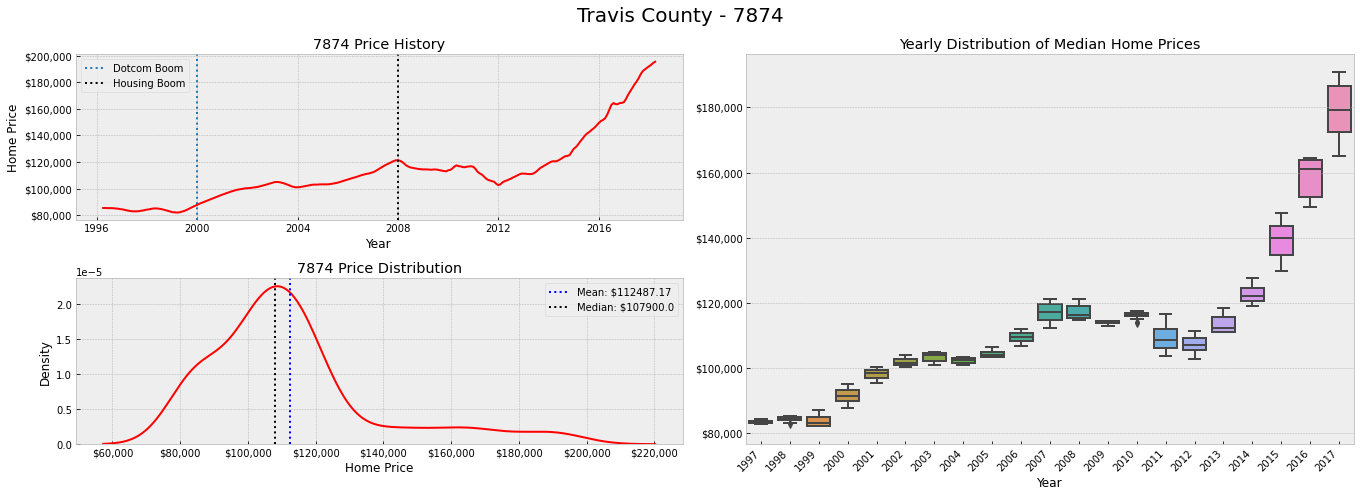

In [77]:
zip_eda(df_78744, 7874, 'Travis')

- Minimal impact on prices during dotcom crash and but large downturn after 2008 with another dip in 2012
    - Looks like the median house price recovered in 2013
- Data is right skewed based on mean > median
- Lowest standard deviation in Travis County of those compared agasint
- From 1997 to 2006 homes had minimal spread but 2007 and 2008 had more variability, spread increased from 2015 onwards
    - Suggests transactions are taking place at a wider range of values

<AxesSubplot:xlabel='time'>

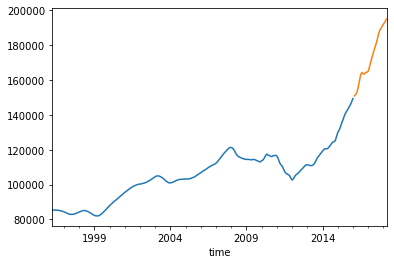

In [78]:
train_78744, test_78744 = create_train_test_split(df_78744, 0.9)
train_78744.plot()
test_78744.plot()

Split captures upwards trend and precedes slight dip in 2016

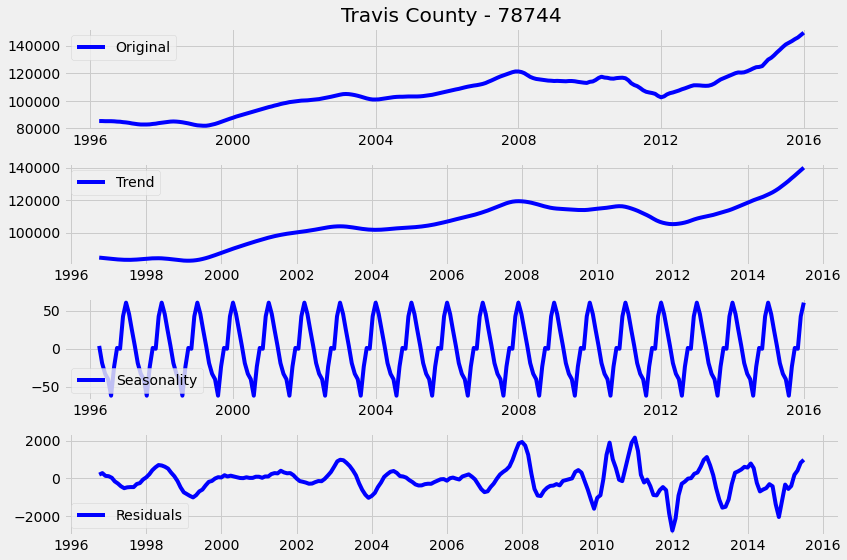

In [79]:
seasonal_decomposition(train_78744, 'Travis', 78744)

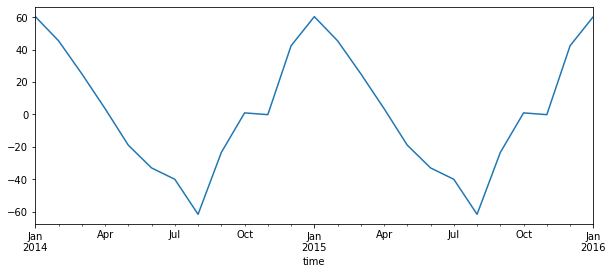

In [80]:
decomposition = seasonal_decompose(train_78744,model='Additive')
seasonal = decomposition.seasonal
seasonal.plot(figsize=(10,4), xlim=('2014-01-01', '2016-01-01'));

- There is an upward trend beginning in 2012
- Data is annually seasonal with peaks in months (Nov-Feb) and dips in summer (June-Sept)
- Seasonality appears constant
- Residuals suggest more variance in 2008 and a similar amount following that point in time
- Looks like data needs 1 degree of differencing on seasonality

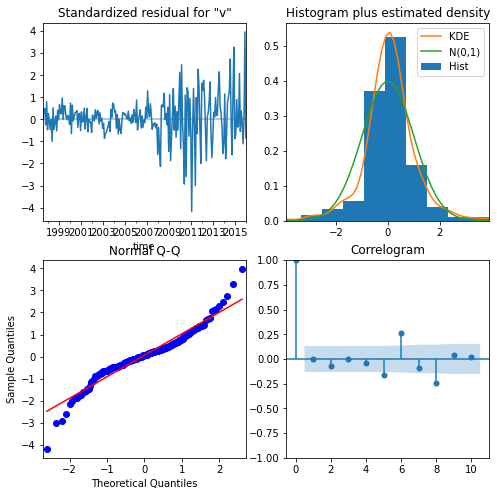

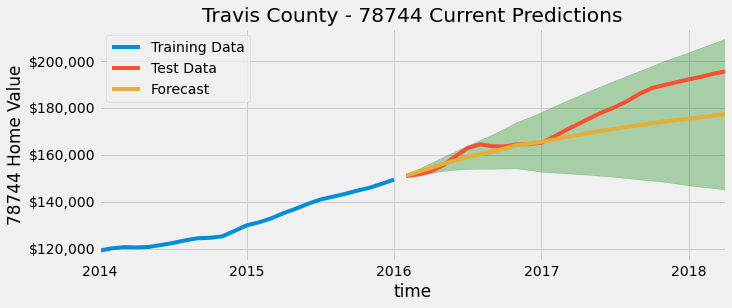

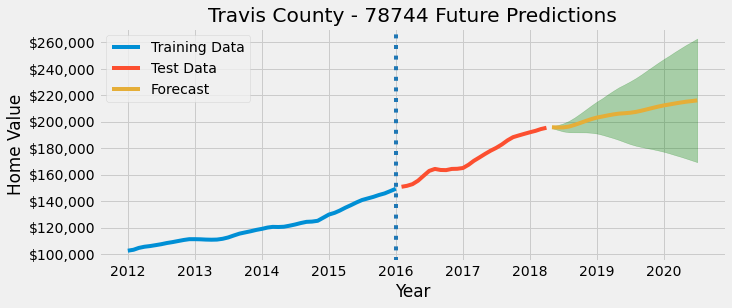

In [81]:
fig_78744, future_78744, forecast_df_78744, roi_78744 = model_predictions(train_78744, test_78744, df_78744, 78744, 'Travis')

In [82]:
roi_78744

{'Lower CI': [-0.13159585971374968, 86840.41402862503, -13159.585971374967],
 'Upper CI': [0.33719764159761295, 133719.7641597613, 33719.76415976131],
 'Forecast': [0.10362592834049635, 110362.59283404963, 10362.592834049632]}

- Current predictions
    - Model captures general trend compared to test predictions, all test values fall within CI
    - It tends to undershoot the test data, especially after 2017
    - As test data tapers off the model does capture that 
- Future predictions
    - Model follows trend of test data
    - Slopes upward a bit in mid - 2019
- An investment of \$100,000 today (05/01/2018) by 07/01/2020 would yield (ROI):
    - Conservative estimate: -13.2\% (-\$13,159)
    - Mean estimate: 10.4% (+\$10,362)
    - Upper estimate: 33.7\% (+\$33,719)

## Travis County Conclusions

- Model all 3 predictions in single graph
- Looks at risk assesment
- Observe correlation between the 3

In [83]:
def county_forecast_comparison(df1_all, zip_1, forecast1, df2_all, zip_2, forecast2, df3_all, zip_3, forecast3):
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(figsize=(12,5))

        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.yaxis.set_major_formatter(tick)

        # 78758
        ax.plot(df1_all['2006-01-01':], label=zip_1)
        ax.plot(forecast1['Forecast'], label=f'{zip_1} Forecast')
        ax.fill_between(forecast1.index,forecast1['Lower CI'], forecast1['Upper CI'], alpha=0.3,
                       color='red')
        ax.axvline(df1_all.index[-1], ls =':', lw=2)

        #78721
        ax.plot(df2_all['2006-01-01':], label=zip_2)
        ax.plot(forecast2['Forecast'], label=f'{zip_2} Forecast')
        ax.fill_between(forecast2.index,forecast2['Lower CI'], forecast2['Upper CI'], alpha=0.3,
                       color='green')

        #78744
        ax.plot(df3_all['2006-01-01':], label=zip_3)
        ax.plot(forecast3['Forecast'], label=f'{zip_3} Forecast')
        ax.fill_between(forecast3.index,forecast3['Lower CI'], forecast3['Upper CI'], alpha=0.2,
                       color='blue')

        ax.legend(loc=2)

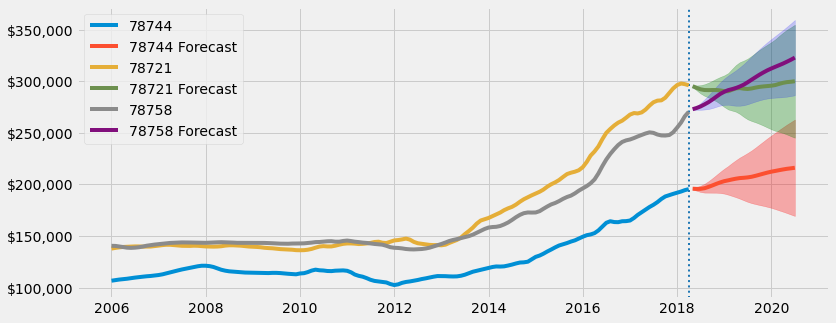

In [84]:
county_forecast_comparison(df_78744, 78744, forecast_df_78744, df_78721, 78721, forecast_df_78721,  df_78758, 78758, forecast_df_78758)

In [85]:
def county_forecast_perc_comparison(roi1, zip_1, roi2, zip_2, roi3, zip_3):
    test_1 = pd.DataFrame(roi1, index=[f'{zip_1} Perc Change', 'Val', '$ Diff'])
    test_2 = pd.DataFrame(roi2, index=[f'{zip_2} Perc Change', 'Val', '$ Diff'])
    test_3 = pd.DataFrame(roi3, index=[f'{zip_3} Perc Change', 'Val', '$ Diff'])
    df = pd.concat([test_1, test_2, test_3], axis=0)
    return df

In [86]:
travis_perc_comparison = county_forecast_perc_comparison(roi_78758, 78758, roi_78721, 78721, roi_78744, 78744)

In [87]:
travis_perc_comparison

,Lower CI,Upper CI,Forecast
78758 Perc Change,0.052020,0.313686,0.183164
Val,105202.018367,131368.640082,118316.368735
$ Diff,5202.018367,31368.640082,18316.368735
78721 Perc Change,-0.166664,0.198226,0.016314
Val,83333.606297,119822.637685,101631.438376
$ Diff,-16666.393703,19822.637685,1631.438376
78744 Perc Change,-0.131596,0.337198,0.103626
Val,86840.414029,133719.764160,110362.592834
$ Diff,-13159.585971,33719.764160,10362.592834


In [88]:
def corr_check(df1, df2, df3, zip_1, zip_2, zip_3):
    df = pd.concat([df1, df2, df3], axis=1)
    df.columns = [zip_1, zip_2, zip_3]
    return df.corr()

In [89]:
corr_check(df_78758, df_78721, df_78744, 78758, 78721, 78744)

,78758,78721,78744
78758,1.000000,0.967931,0.970744
78721,0.967931,1.000000,0.980363
78744,0.970744,0.980363,1.000000


## Bexar County Modeling
- Bexar: [78212, 78201, 78210]

### 78212: EDA and SARIMAX

In [90]:
# Create 78212 dataframe

df_78212=create_zip_data(Bexar_dict_full, 78212)

In [97]:
df_78212

,value
time,
1996-04-01,79500.0
1996-05-01,79800.0
1996-06-01,80100.0
1996-07-01,80300.0
1996-08-01,80500.0
...,...
2017-12-01,217200.0
2018-01-01,222300.0
2018-02-01,225800.0


(<Figure size 1368x504 with 3 Axes>,
                value
 count     265.000000
 mean   115321.509434
 std     31134.681006
 min     79100.000000
 25%     89900.000000
 50%    114600.000000
 75%    121900.000000
 max    229100.000000)

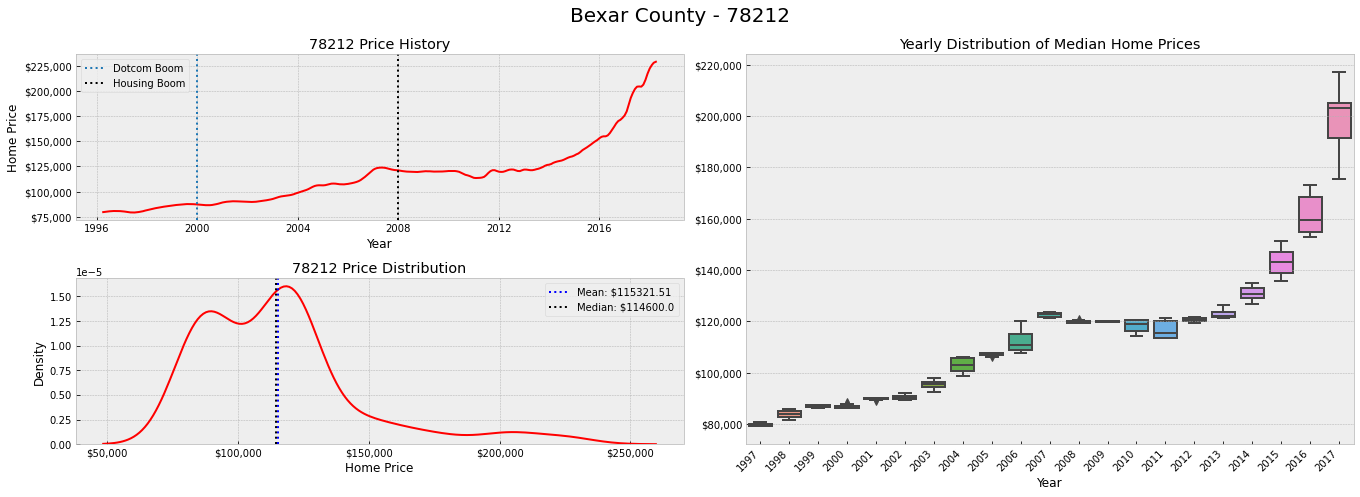

In [91]:
zip_eda(df_78212, 78212, 'Bexar')

<AxesSubplot:xlabel='time'>

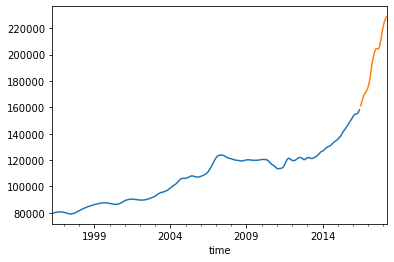

In [92]:
train_78212, test_78212 = create_train_test_split(df_78212, 0.92)
train_78212.plot()
test_78212.plot()

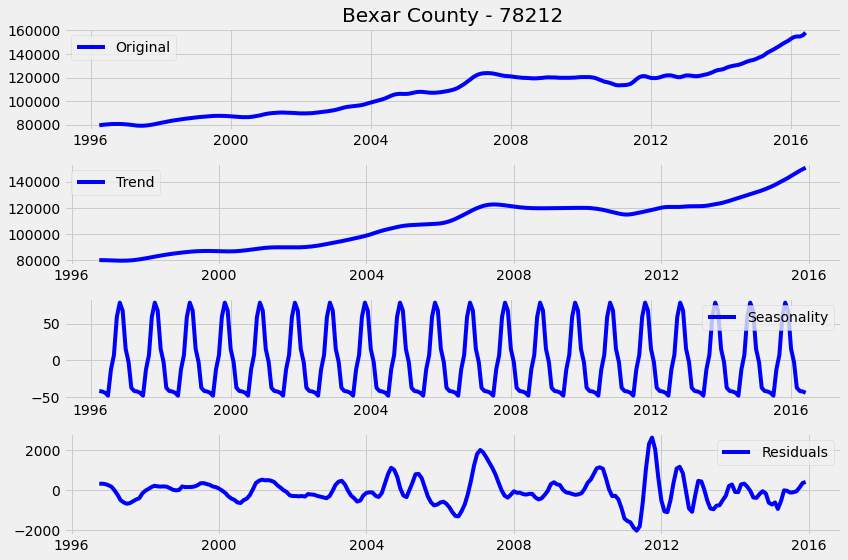

In [93]:
seasonal_decomposition(train_78212, 'Bexar', 78212)

In [94]:
summary, ARMA_order, seasonal_order=find_auto_order(train_78212)

In [95]:
seasonal_order

(1, 0, 2, 12)

In [96]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  243
Model:             SARIMAX(1, 2, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -1677.273
Date:                                 Wed, 16 Jun 2021   AIC                           3370.546
Time:                                         18:35:53   BIC                           3398.424
Sample:                                              0   HQIC                          3381.778
                                                 - 243                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6776      0.113      6.019      0.000       0.457       0.898
ma.L1         -0.4557      0.119     -3.834      0.000      -0.689      -0.223
ma.L2         -0.2212      0.038     -5.834      0.000      -0.296      -0.147
ma.L3         -0.0834      0.038     -2.176      0.030      -0.158      -0.008
ar.S.L12      -0.7612      0.195     -3.912      0.000      -1.143      -0.380
ma.S.L12       0.6051      0.198      3.059      0.002       0.217       0.993
ma.S.L24      -0.1908      0.043     -4.460      0.000      -0.275      -0.107
sigma2      5.047e+04   3190.023     15.822      0.000    4.42e+04    5.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.98   Jarque-Bera (JB):                83.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.37   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

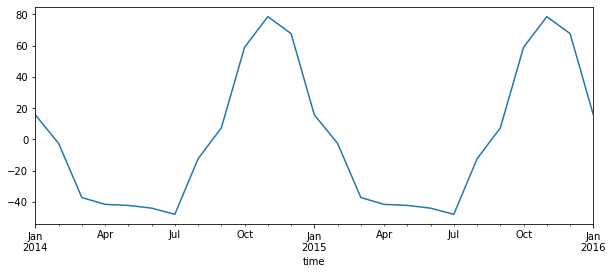

In [97]:
decomposition = seasonal_decompose(train_78212,model='Additive')
seasonal = decomposition.seasonal
seasonal.plot(figsize=(10,4), xlim=('2014-01-01', '2016-01-01'));

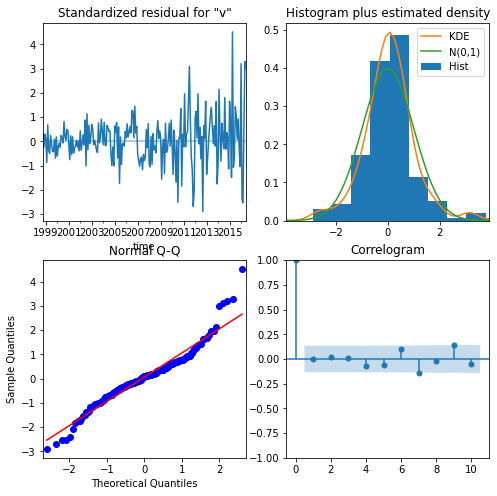

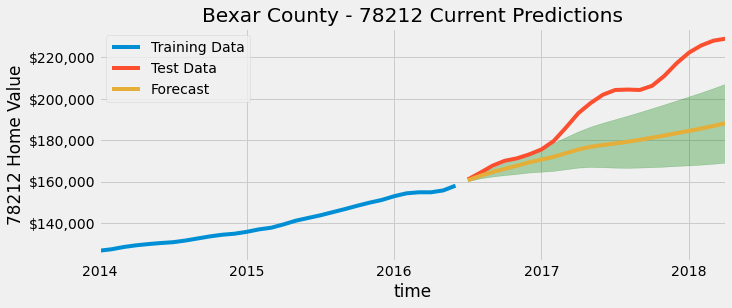

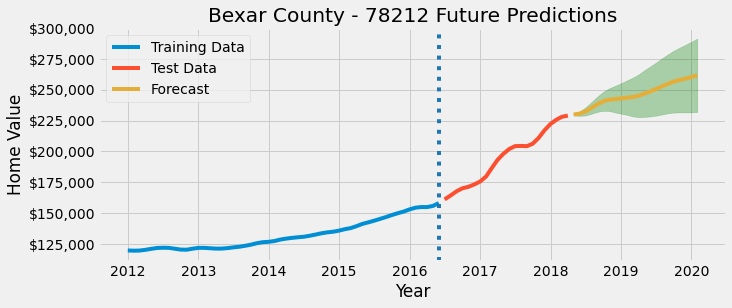

In [98]:
fig_78212, future_78212, forecast_df_78212, roi_78212 = model_predictions(train_78212, test_78212, df_78212, 78212, 'Bexar')

### 78201: EDA and SARIMAX

In [99]:
# Create 78201 dataframe

df_78201=create_zip_data(Bexar_dict_full, 78201)

(<Figure size 1368x504 with 3 Axes>,
                value
 count     265.000000
 mean    78893.584906
 std     17210.957034
 min     59100.000000
 25%     64800.000000
 50%     78500.000000
 75%     84300.000000
 max    140600.000000)

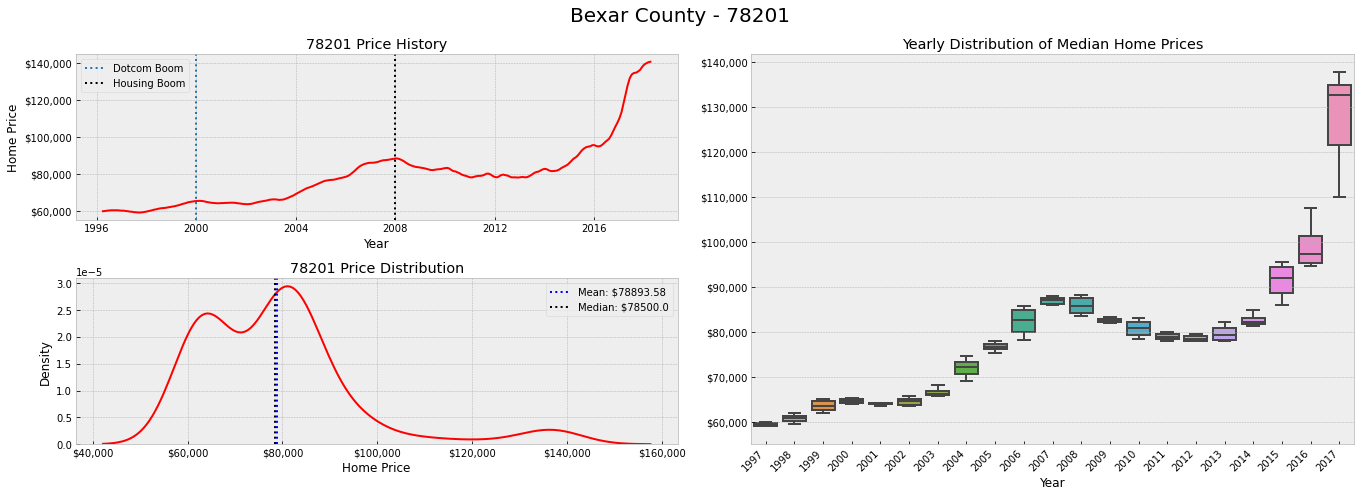

In [100]:
zip_eda(df_78201, 78201, 'Bexar')

<AxesSubplot:xlabel='time'>

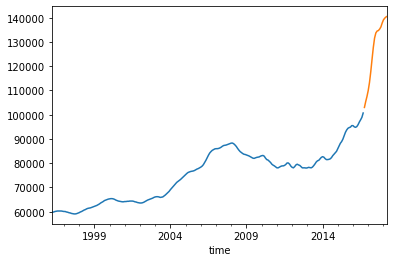

In [101]:
train_78201, test_78201 = create_train_test_split(df_78201, 0.93)
train_78201.plot()
test_78201.plot()

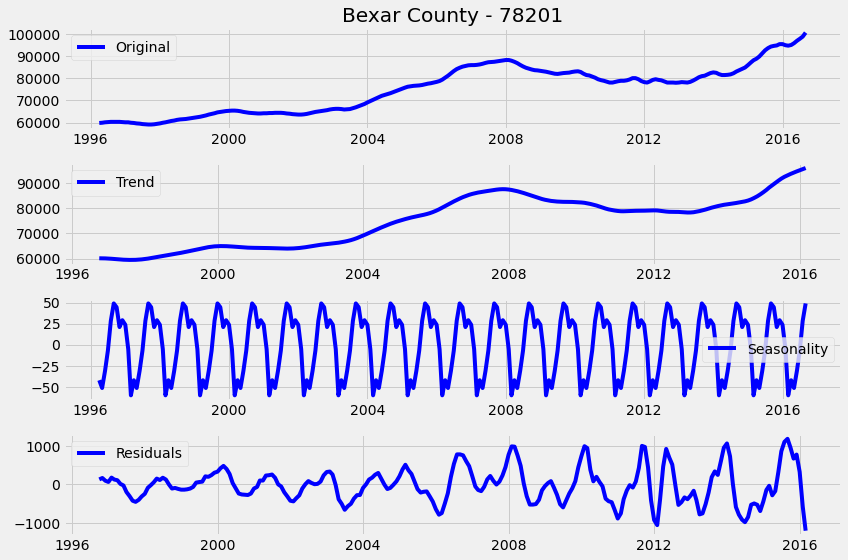

In [102]:
seasonal_decomposition(train_78201, 'Bexar', 78201)

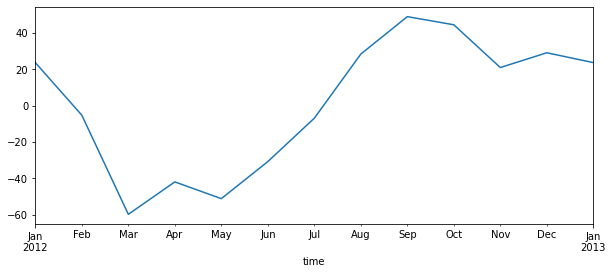

In [103]:
decomposition = seasonal_decompose(train_78201,model='Additive')
seasonal = decomposition.seasonal
seasonal.plot(figsize=(10,4), xlim=('2012-01-01', '2013-01-01'));

In [123]:
train_78201

time
1996-04-01    59800.0
1996-05-01    59900.0
1996-06-01    60100.0
1996-07-01    60200.0
1996-08-01    60300.0
               ...   
2014-10-01    83700.0
2014-11-01    84300.0
2014-12-01    84900.0
2015-01-01    86000.0
2015-02-01    87200.0
Freq: MS, Name: value, Length: 227, dtype: float64

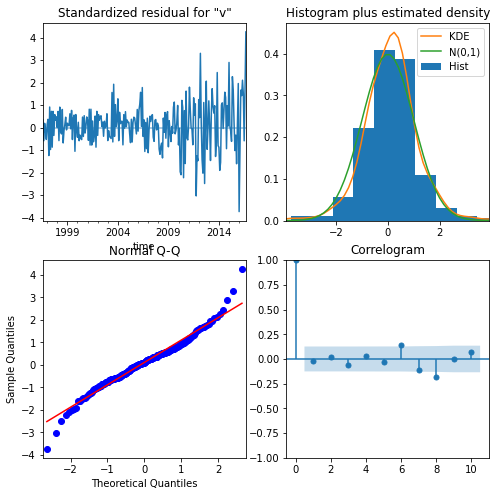

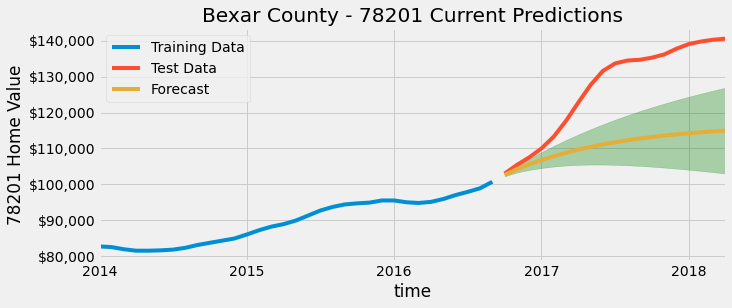

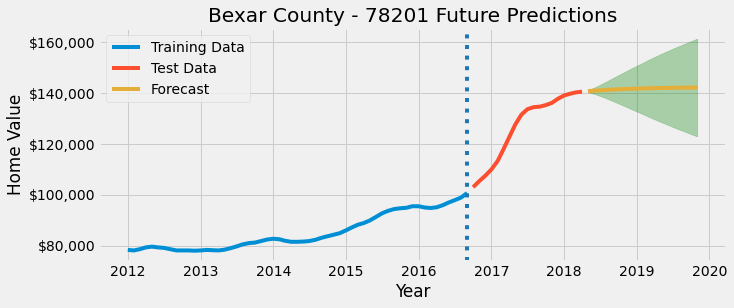

In [104]:
fig_78201, future_78201, forecast_df_78201, roi_78201 = model_predictions(train_78201, test_78201, df_78201, 78201, 'Bexar')

In [105]:
summary, ARMA_order, seasonal_order=find_auto_order(train_78201)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  246
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1725.265
Date:                Wed, 16 Jun 2021   AIC                           3460.530
Time:                        18:37:27   BIC                           3478.037
Sample:                             0   HQIC                          3467.580
                                - 246                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.7160     11.561      3.522      0.000      18.058      63.374
ar.L1          0.8125      0.028     29.353      0.000       0.758       0.867
ar.L2         -0.2326      0.046     -5.103      0.000      -0.322      -0.143
ar.L3          0.1061      0.032      3.318      0.001       0.043       0.169
sigma2      3.285e+04   1825.662     17.991      0.000    2.93e+04    3.64e+04
===================================================================================
Ljung-Box (L1) (Q):                  17.85   Jarque-Bera (JB):              1972.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
seasonal_order

(0, 0, 0, 12)

### 78210: EDA and SARIMAX

In [106]:
# Create 78210 dataframe

df_78210=create_zip_data(Bexar_dict_full, 78210)

(<Figure size 1368x504 with 3 Axes>,
                value
 count     265.000000
 mean    67078.867925
 std     12593.568233
 min     50500.000000
 25%     56600.000000
 50%     68400.000000
 75%     72200.000000
 max    119400.000000)

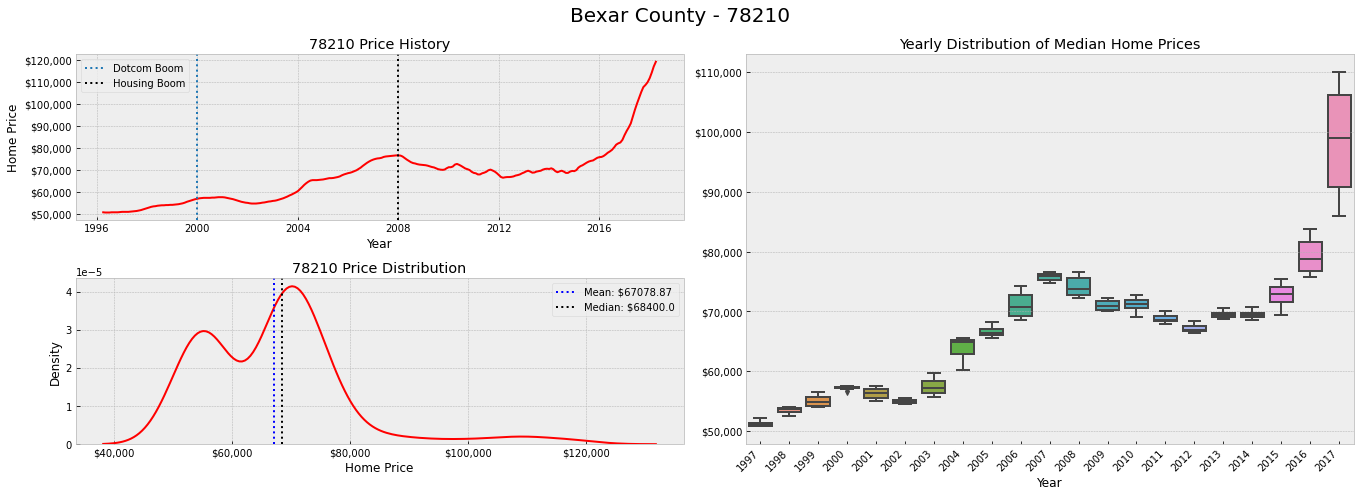

In [107]:
zip_eda(df_78210, 78210, 'Bexar')

In [108]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_78210, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


NameError: name 'X' is not defined

In [ ]:
train_78210, test_78210 = create_train_test_split(df_78210, 0.93)
train_78210.plot()
test_78210.plot()

In [ ]:
seasonal_decomposition(train_78210, 'Bexar', 78210)

In [ ]:
decomposition = seasonal_decompose(train_78210,model='Additive')
seasonal = decomposition.seasonal
seasonal.plot(figsize=(10,4), xlim=('2012-01-01', '2013-01-01'));

In [ ]:
fig_78210, future_78210, forecast_df_78210, roi_78210 = model_predictions(train_78210, test_78210, df_78210, 78210, 'Bexar')

# Step 6: Interpreting Results

# Testing Functions

In [ ]:

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(12,5))
    
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    # 78758
    ax.plot(df_78758['2006-01-01':], label='78758')
    ax.plot(forecast_df_78758['Forecast'], label='78758 Forecast')
    ax.fill_between(forecast_df.index,forecast_df_78758['Lower CI'], forecast_df_78758['Upper CI'], alpha=0.3,
                   color='green')
    ax.axvline(df_78758.index[-1], ls =':')

    #78721
    ax.plot(df_78721['2006-01-01':], label='78721')
    ax.plot(forecast_df_78721['Forecast'], label='78721 Forecast')
    ax.fill_between(forecast_df.index,forecast_df_78721['Lower CI'], forecast_df_78721['Upper CI'], alpha=0.3,
                   color='red')

    #78744
    ax.plot(df_78744['2006-01-01':], label='78744')
    ax.plot(forecast_df_78744['Forecast'], label='78744 Forecast')
    ax.fill_between(forecast_df.index,forecast_df_78744['Lower CI'], forecast_df_78744['Upper CI'], alpha=0.3,
                   color='blue')

    ax.legend(loc=2)

In [ ]:
summary, ARMA_order, seasonal_order=find_auto_order(train_78210)
summary

In [ ]:
seasonal_order

In [ ]:
model = SARIMAX(train_78210,order=(1, 2, 2), seasonal_order=(2, 2, 2, 12),
                        enforce_stationarity=False, enforce_invertibility=False,
                        freq='MS')


In [ ]:
res = model.fit(maxiter=200)
res.summary()

In [ ]:
fore78210 = res.get_forecast(steps=len(test_78210))

In [ ]:
# save forecasted mean and upper/lower ci as df
forecast_df = fore78210.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = fore78210.predicted_mean
forecast_df

In [ ]:
train_78210.plot()
test_78210.plot()
forecast_df['Forecast'].plot()

Trying another gridsearch method

In [ ]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
aic_scores = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(train_78210, order=comb, seasonal_order=combs, enforce_invertibility=False, enforce_stationarity=False)
            output = mod.fit(maxiter=100)
            aic_scores.append([comb, combs, output.aic])
        except:
            contiue
aic_scores

In [ ]:
pd.DataFrame(aic_scores).sort_values(2)

In [ ]:
def SARIMAX_man_results(train_data, arma_order, seasonal_order):
    """
    Takes a training data and ARMA/Seasonal order and fits a SARIMAX model with specied order and fits
    different parameters and returns the best SARIMAX model based on AIC value
    Parameters:
    Train data, seasonal/arma order
    Returns:
    Dictionary with various iterations of parameters and their AIC score and dictionary with the best 
    parameters
    """
    grid_results = []
    grid_tests = []
    mle_regression=[True,False]
    concentrate_scale = [True, False]
    results_dict = {}
    best_params = {}

    for mle in mle_regression:
        for scale in concentrate_scale:
            model = SARIMAX(train_data,order=arma_order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False,
                        mle_regression=mle, concentrate_scale=scale,freq='MS', k_trend=2)
            results = model.fit()
            score_ = results.aic

            grid_tests.append([mle, scale])
            grid_results.append(score_)
    df = pd.DataFrame(grid_tests, grid_results).sort_index()
    df = df.rename(columns={0: 'MLE_Regression', 1: 'Concentrate_Scale'})
    results_dict['grid_search'] = df
    diagnostics = results.plot_diagnostics(figsize=(8,8))
    results_dict['diag_summary'] = diagnostics

    best_params['arma_order'] = arma_order
    best_params['seasonal_order'] = seasonal_order
    best_params['MLE_Regression'] = seasonal_order
    best_params['Concentrate_Scale'] = seasonal_order


    return results_dict, best_params

In [ ]:
def SARIMAX_man_results(train_data, arma_order, seasonal_order):
    """
    Takes a training data and ARMA/Seasonal order and fits a SARIMAX model with specied order and fits
    different parameters and returns the best SARIMAX model based on AIC value
    Parameters:
    Train data, seasonal/arma order
    Returns:
    Dictionary with various iterations of parameters and their AIC score and dictionary with the best 
    parameters
    """
    grid_results = []
    grid_tests = []
    mle_regression=[True,False]
    concentrate_scale = [True, False]
    results_dict = {}
    best_params = {}

    for mle in mle_regression:
        for scale in concentrate_scale:
            model = SARIMAX(train_data,order=arma_order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False,
                        mle_regression=mle, concentrate_scale=scale,freq='MS', k_trend=2)
            results = model.fit()
            score_ = results.aic

            grid_tests.append([mle, scale])
            grid_results.append(score_)
    df = pd.DataFrame(grid_tests, grid_results).sort_index()
    df = df.rename(columns={0: 'MLE_Regression', 1: 'Concentrate_Scale'})
    results_dict['grid_search'] = df
    diagnostics = results.plot_diagnostics(figsize=(8,8))
    results_dict['diag_summary'] = diagnostics

    best_params['arma_order'] = arma_order
    best_params['seasonal_order'] = seasonal_order
    best_params['MLE_Regression'] = seasonal_order
    best_params['Concentrate_Scale'] = seasonal_order


    return results_dict, best_params

In [155]:
import matplotlib.ticker as mtick

def model_predictions(train_data, test_data, all_data, code, county):
    """
    Uses all helper functions to create diagnostic summary, forecast on test data, and future predictions
    Parameters:
    Training data, test data, all data, zip code, and county
    Returns:
    Plot showing diagnostics and forecasts. Dictinary with predictions in the future
    """
    summary, arma_order, seasonal_order = find_auto_order(train_data)
    best_params = SARIMAX_man_results(train_data, arma_order, seasonal_order)
    best_model = fit_final_model(train_data, arma_order, seasonal_order, 
                                 best_params['MLE_Regression'], best_params['Concentrate_Scale'])
    forecast_df=get_forecast(best_model, test_data)
    test_forecast_fig=plot_forecast(train_data, test_data, forecast_df, code, county)
    bestall_model=fitall_final_model(all_data, arma_order, seasonal_order, 
                        best_params['MLE_Regression'], best_params['Concentrate_Scale'])
    
    fig, forecast_dict, forecast_df=plot_future_forecast(bestall_model, test_data, train_data, code, county)
    roi_helper = roi_dict(forecast_df)
    return fig, forecast_dict, forecast_df, roi_helper